<a href="https://colab.research.google.com/github/ManisMalakar/Artifical-Neural-Network/blob/main/Mask_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#Importing the needed libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [8]:
#Importing the files to train
from google.colab import files
uploaded=files.upload()


Saving dataset.zip to dataset.zip


In [9]:
#Unzipping the file
!unzip /content/dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/with_mask/with_mask279.jpg  
  inflating: __MACOSX/dataset/with_mask/._with_mask279.jpg  
  inflating: dataset/with_mask/with_mask245.jpg  
  inflating: __MACOSX/dataset/with_mask/._with_mask245.jpg  
  inflating: dataset/with_mask/0_0_7 copy 23.jpg  
  inflating: __MACOSX/dataset/with_mask/._0_0_7 copy 23.jpg  
  inflating: dataset/with_mask/1_0_13 2.jpg  
  inflating: __MACOSX/dataset/with_mask/._1_0_13 2.jpg  
  inflating: dataset/with_mask/with_mask523.jpg  
  inflating: __MACOSX/dataset/with_mask/._with_mask523.jpg  
  inflating: dataset/with_mask/0_1_3.jpg  
  inflating: __MACOSX/dataset/with_mask/._0_1_3.jpg  
  inflating: dataset/with_mask/with_mask537.jpg  
  inflating: __MACOSX/dataset/with_mask/._with_mask537.jpg  
  inflating: dataset/with_mask/with_mask251.jpg  
  inflating: __MACOSX/dataset/with_mask/._with_mask251.jpg  
  inflating: dataset/with_mask/0_0_6 copy 5.jpg  
  inflating: __MACOSX/dataset/w

In [25]:
# Initializing the initial learning rate, number of epochs to train for and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = "/content/dataset"
CATEGORIES = ["with_mask", "without_mask"]


In [14]:
# Grabbing the list of images in our dataset directory, then initializing 
#the list of data and class images
print("Loading images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

Loading images...


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [15]:
# Performing one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [17]:
#Constructing the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [18]:
# Loading the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 0s 0us/step


In [19]:
# Constructing the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [20]:
# Placing the head FC model on top of the base model 
model = Model(inputs=baseModel.input, outputs=headModel)


In [21]:
# Looping over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False


In [22]:
# Compiling our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])


In [26]:
# Training the head of the network
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)


Epoch 1/20
95/95 [==============================] - 155s 2s/step - loss: 0.3311 - accuracy: 0.9011 - val_loss: 0.1628 - val_accuracy: 0.9765
Epoch 2/20
95/95 [==============================] - 154s 2s/step - loss: 0.1484 - accuracy: 0.9664 - val_loss: 0.0961 - val_accuracy: 0.9791
Epoch 3/20
95/95 [==============================] - 152s 2s/step - loss: 0.1005 - accuracy: 0.9730 - val_loss: 0.0740 - val_accuracy: 0.9804
Epoch 4/20
95/95 [==============================] - 151s 2s/step - loss: 0.0849 - accuracy: 0.9776 - val_loss: 0.0623 - val_accuracy: 0.9804
Epoch 5/20
95/95 [==============================] - 152s 2s/step - loss: 0.0685 - accuracy: 0.9832 - val_loss: 0.0542 - val_accuracy: 0.9831
Epoch 6/20
95/95 [==============================] - 155s 2s/step - loss: 0.0658 - accuracy: 0.9792 - val_loss: 0.0493 - val_accuracy: 0.9817
Epoch 7/20
95/95 [==============================] - 160s 2s/step - loss: 0.0534 - accuracy: 0.9842 - val_loss: 0.0459 - val_accuracy: 0.9844
Epoch 8/20
95

In [27]:

# Making predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)

# For each image in the testing set finding the index of the label with 
#corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# Displaying a formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



[INFO] saving mask detector model...


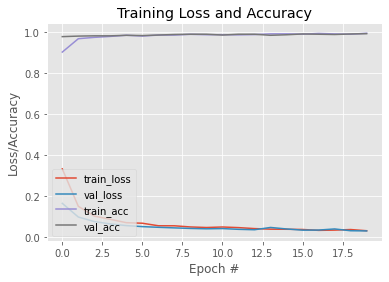

In [28]:
# Serializing the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# Plotting the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")